In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from pathlib import Path

In [4]:
PROC = Path("../data/processed/AAPL_clean.csv")
df = pd.read_csv(PROC, parse_dates=["Date"], usecols=['Date','Close'])

In [5]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled = scaler.fit_transform(df[['Close']])

In [6]:
def create_sequences(data, window_size=50):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i, 0])  # past `window_size` values
        y.append(data[i, 0])                 # next value
    return np.array(X), np.array(y)

In [7]:
window_size = 50
X, y = create_sequences(scaled, window_size)

In [8]:
X = X.reshape((X.shape[0], X.shape[1], 1))
X_train, X_test = X[:-30], X[-30:]
y_train, y_test = y[:-30], y[-30:]

In [9]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(window_size, 1)))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))  # Output layer

c:\Users\jayan\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [10]:
model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.0242 - val_loss: 0.0028
Epoch 2/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0031 - val_loss: 0.0018
Epoch 3/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0029 - val_loss: 0.0061
Epoch 4/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0026 - val_loss: 0.0066
Epoch 5/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0025 - val_loss: 0.0029
Epoch 6/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0025 - val_loss: 0.0011
Epoch 7/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0024 - val_loss: 0.0065
Epoch 8/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0024 - val_loss: 0.0020
Epoch 9/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0022 - val_loss: 0.0012
Epoch 10/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0021 - val_loss: 0.0013
Epoch 11/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0022 - val_loss: 0.0026
Epoch 12/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0

In [11]:
# Replace your recursive prediction loop with this single line
predictions_scaled = model.predict(X_test)

# Inverse transform the results to get the actual prices
y_pred = scaler.inverse_transform(predictions_scaled)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


In [12]:
mae = mean_absolute_error(y_test_actual, y_pred)
rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred))
print("MAE:", mae)
print("RMSE:", rmse)

MAE: 9.043472290039071
RMSE: 10.901000799003794


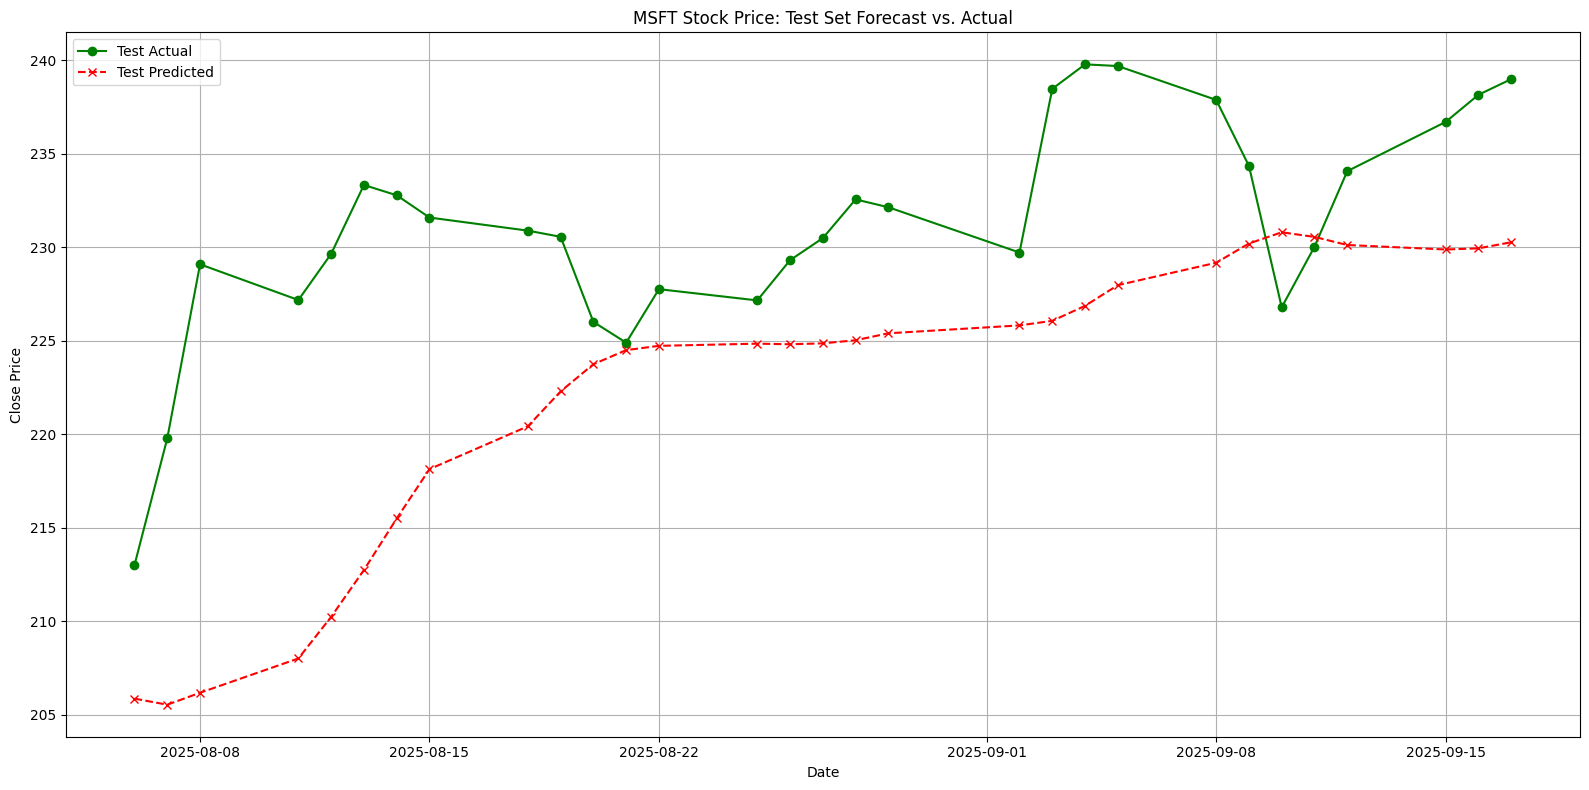

In [13]:
# Get the dates that correspond to the test set (the last 30 days in the dataframe)
test_dates = df['Date'][-30:]

# Plot the test data's actual and predicted close prices
plt.figure(figsize=(16, 8))
plt.plot(test_dates, y_test_actual, label='Test Actual', color='green', marker='o')
plt.plot(test_dates, y_pred, label='Test Predicted', color='red', linestyle='--', marker='x')

# Add titles and labels for clarity
plt.title('MSFT Stock Price: Test Set Forecast vs. Actual')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.tight_layout() # Adjusts plot to ensure everything fits without overlapping
plt.show()